In [1]:
! ls /scratch/Projects/IMMUNEX/segmentation/bin2cell/

bin2cell_output  bin2cell_output_he0.01_gex0.05  bin2cell_output_he0005_gex005


In [2]:
import sys
sys.path.append("/opt/Banksy_py")
import banksy as banksy
import time; import random

from banksy.initialize_banksy import initialize_banksy
from banksy.run_banksy import run_banksy_multiparam
from banksy_utils.color_lists import spagcn_color
from banksy_utils.plot_utils import plot_qc_hist, plot_cell_positions
from banksy_utils.load_data import load_adata, display_adata
from banksy_utils.filter_utils import filter_cells
from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

/opt/Banksy_py/banksy/cluster_methods.py:18: UserWarning: 
No rpy2 installed. BANKSY will run, but mclust will not work.
Note: you can still use the default leiden option for clustering.
Install rpy2 and R in your conda environment if you want to use mclust for clustering.

  warnings.warn(warn_str)
2025-07-10 22:48:24.565617: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 22:48:24.574865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-10 22:48:24.586685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already 

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

# Load the data
sample_id = "IMMUNEX002"

adata = sc.read(f"/scratch/Projects/IMMUNEX/segmentation/bin2cell/bin2cell_output_he0.01_gex0.05/{sample_id}/adata_processed.h5ad")
adata.raw = adata
adata.uns['sample_id'] = sample_id
adata

AnnData object with n_obs × n_vars = 10287064 × 18270
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he', 'labels_he_expanded', 'labels_gex', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial', 'sample_id'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [4]:
# Load the metadata
metadata = pd.read_csv("~/rawdata/IMMUNEX/data/VisiumHD_18_2024_NSCLC.csv")

metadata_sample = metadata[metadata['Sample_code'] == sample_id]
adata.uns["sample_metadata"] = metadata_sample.iloc[0].to_dict()

display(adata.obs.head()) # Display the first few rows of the observation data (cell metadata)

,in_tissue,array_row,array_col,n_counts,destripe_factor,n_counts_adjusted,labels_he,labels_he_expanded,labels_gex,labels_joint,labels_joint_source
s_002um_02587_02503-1,1,2587,2503,28.0,0.823529,21.411765,0,123152,22606,123152,primary
s_002um_01674_00710-1,1,1674,710,2.0,0.233977,6.083413,0,168030,34839,168030,primary
s_002um_02498_02808-1,1,2498,2808,4.0,0.315715,8.208591,119256,119256,0,119256,primary
s_002um_00952_00136-1,1,952,136,1.0,0.143678,3.735632,330594,330594,0,330594,primary
s_002um_00564_00910-1,1,564,910,5.0,0.528161,13.732175,0,291153,0,291153,primary


In [5]:
# Sampling adata 
# Set seed for reproducibility
np.random.seed(42)

# Compute number of cells to sample
n_obs = adata.n_obs
n_sample = int(n_obs * 0.01)
n_sample = int(n_obs * 1)

# Randomly choose indices
sample_indices = np.random.choice(n_obs, size=n_sample, replace=False)

# Subset the AnnData object
adata_sampled = adata[sample_indices].copy()

# Inspect new shape
print(adata_sampled)


AnnData object with n_obs × n_vars = 10287064 × 18270
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he', 'labels_he_expanded', 'labels_gex', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial', 'sample_id', 'sample_metadata'
    obsm: 'spatial', 'spatial_cropped_150_buffer'


In [6]:
adata_sampled.obs['cell_id'] = adata_sampled.obs['labels_joint'].astype(str)
adata_cells = adata_sampled[adata_sampled.obs['labels_joint'] > 0].copy()
adata_cells.var['mt'] = adata_sampled.var_names.str.upper().str.startswith('MT-')

# Use CSR for efficient row slicing
X = adata_cells.X.tocsr()
cell_ids = adata_cells.obs['cell_id'].values
print('Analysing')

# Map cell_id to integer index
unique_ids, inverse_idx = np.unique(cell_ids, return_inverse=True)
n_cells = len(unique_ids)
n_genes = X.shape[1]
print('Analysing')

# Initialize empty matrix to store the result
# Result will be dense at the end, but small: (n_cells x n_genes)
result = np.zeros((n_cells, n_genes))
print('Analysing')

# Efficient sparse row-by-row summing
for i in tqdm(range(X.shape[0])):
    result[inverse_idx[i]] += X[i].toarray()[0]

# Convert to DataFrame
grouped_expr = pd.DataFrame(result, index=unique_ids, columns=adata_cells.var_names)



Analysing
Analysing
Analysing


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7998990/7998990 [34:56<00:00, 3815.86it/s]


In [7]:
adata_cells = AnnData(X=sp.csr_matrix(grouped_expr.values))
adata_cells.obs_names = grouped_expr.index
adata_cells.var_names = grouped_expr.columns # Gene Names
adata_cells.shape

(428621, 18270)

In [8]:
# and 'cell_id' is the grouping key used to generate grouped_expr
# 1. Get a mapping from cell_id → average spatial position
cell_coords = adata_sampled.obs[['cell_id']].copy()
cell_coords['x'] = adata_sampled.obsm['spatial'][:, 0]
cell_coords['y'] = adata_sampled.obsm['spatial'][:, 1]

# 2. Average spatial position per cell
mean_coords = cell_coords.groupby('cell_id')[['x', 'y']].mean()

# 3. Match to your grouped_expr.index (cell IDs)
mean_coords = mean_coords.loc[grouped_expr.index]

# 4. Assign to obsm
adata_cells.obsm['spatial'] = mean_coords.values

# Copy the spatial dictionary to cdata
library_id = list(adata_sampled.uns['spatial'].keys())[0]
adata_cells.uns['spatial'] = {
    library_id: adata_sampled.uns['spatial'][library_id]
}
adata_cells

AnnData object with n_obs × n_vars = 428621 × 18270
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
# Add metadata
# Step 1: Copy gene metadata (var) for the grouped expression matrix
adata_cells.var = adata_sampled.var.loc[grouped_expr.columns].copy()
adata_cells.var_names_make_unique()

# Step 2: Aggregate metadata per reconstructed cell
meta = adata_sampled.obs.groupby('cell_id').agg({
    'n_counts': 'sum',
})
# - Number of bins per cell (count of occurrences)
meta['n_bins'] = adata_sampled.obs['cell_id'].value_counts()
meta.index.name = 'cell_id'

# Step 3: Reorder metadata to match cell ordering in grouped_expr
meta = meta.loc[grouped_expr.index]

# Step 4: Assign aggregated metadata as the new obs for reconstructed cells
adata_cells.obs = meta

# Step 5: Copy over select entries from uns
for k in ['sample_id', 'sample_metadata', 'bin2cell']:
    if k in adata.uns:
        adata_cells.uns[k] = adata.uns[k]

# Step 6: Copy full spatial metadata
adata_cells.uns['spatial'] = adata.uns['spatial']

# Done
adata_cells


AnnData object with n_obs × n_vars = 428621 × 18270
    obs: 'n_counts', 'n_bins'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

## Cropped viz

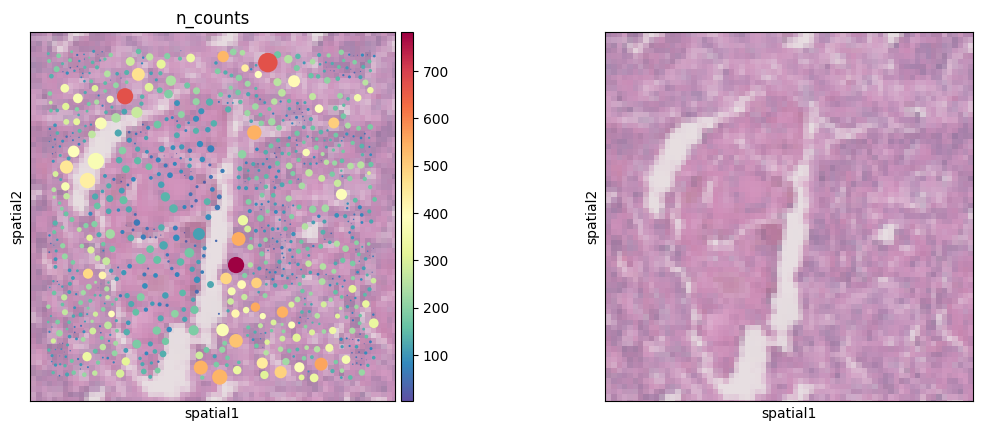

In [10]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

crop_axis_fraction = 0.05  # how much to crop around the center

# Get spatial coordinates
spatial_coords = adata_cells.obsm['spatial'].copy()

# Compute coordinate bounds and center
x_min, x_max = np.min(spatial_coords[:, 0]), np.max(spatial_coords[:, 0])
y_min, y_max = np.min(spatial_coords[:, 1]), np.max(spatial_coords[:, 1])
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Define crop bounds around center
x0 = center_x - (x_max - x_min) * crop_axis_fraction / 2
x1 = center_x + (x_max - x_min) * crop_axis_fraction / 2
y0 = center_y - (y_max - y_min) * crop_axis_fraction / 2
y1 = center_y + (y_max - y_min) * crop_axis_fraction / 2

# Find cells within crop
within_crop = (
    (spatial_coords[:, 0] >= x0) & (spatial_coords[:, 0] <= x1) &
    (spatial_coords[:, 1] >= y0) & (spatial_coords[:, 1] <= y1)
)
adata_cropped = adata_cells[within_crop, :].copy()

# Normalize n_bins to define spot sizes (you can adjust scaling)
sizes = adata_cropped.obs['n_bins']
sizes_normalized = 10 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cropped,
    color=['n_counts',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)


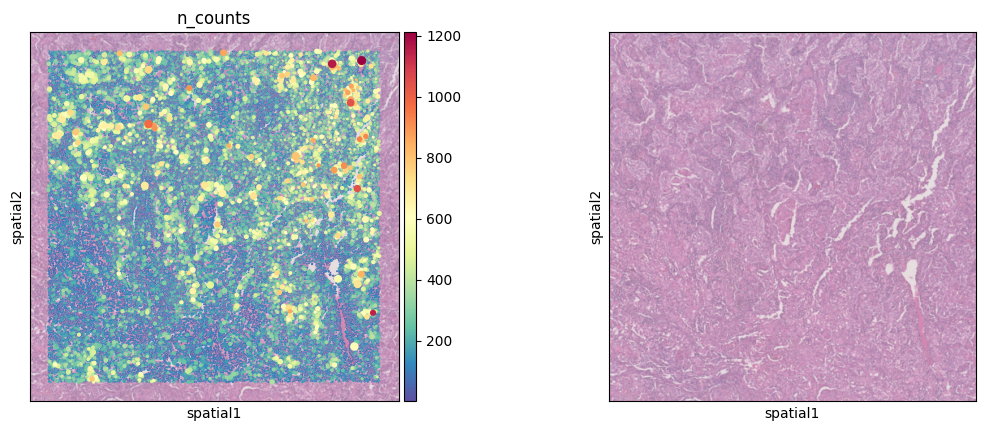

In [11]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

crop_axis_fraction = 0.33  # how much to crop around the center

# Get spatial coordinates
spatial_coords = adata_cells.obsm['spatial'].copy()

# Compute coordinate bounds and center
x_min, x_max = np.min(spatial_coords[:, 0]), np.max(spatial_coords[:, 0])
y_min, y_max = np.min(spatial_coords[:, 1]), np.max(spatial_coords[:, 1])
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Define crop bounds around center
x0 = center_x - (x_max - x_min) * crop_axis_fraction / 2
x1 = center_x + (x_max - x_min) * crop_axis_fraction / 2
y0 = center_y - (y_max - y_min) * crop_axis_fraction / 2
y1 = center_y + (y_max - y_min) * crop_axis_fraction / 2

# Find cells within crop
within_crop = (
    (spatial_coords[:, 0] >= x0) & (spatial_coords[:, 0] <= x1) &
    (spatial_coords[:, 1] >= y0) & (spatial_coords[:, 1] <= y1)
)
adata_cropped = adata_cells[within_crop, :].copy()

# Normalize n_bins to define spot sizes (you can adjust scaling)
sizes = adata_cropped.obs['n_bins']
sizes_normalized = 30 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cropped,
    color=['n_counts',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


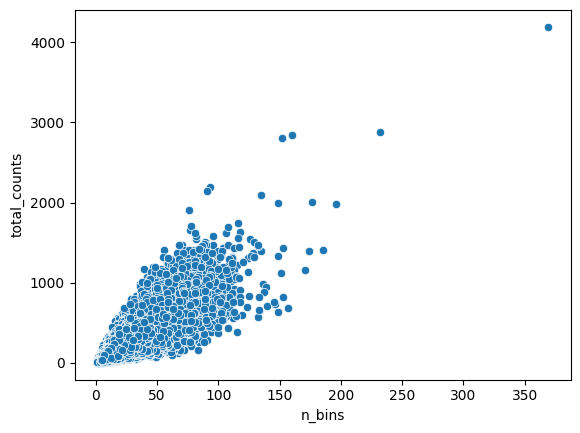

In [12]:
sc.pp.calculate_qc_metrics(adata_cells, inplace=True)
adata_cells.obs['n_bins'] = adata_cells.obs['n_bins'].astype(float)
sns.scatterplot(x=adata_cells.obs['n_bins'], y=adata_cells.obs['total_counts'])
plt.show()


In [13]:
adata_cells

AnnData object with n_obs × n_vars = 428621 × 18270
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

## QC Adata

In [14]:
import sys
sys.path.append("/opt/Banksy_py")
import banksy as banksy
import time; import random

from banksy.initialize_banksy import initialize_banksy
from banksy.run_banksy import run_banksy_multiparam
from banksy_utils.color_lists import spagcn_color
from banksy_utils.plot_utils import plot_qc_hist, plot_cell_positions
from banksy_utils.load_data import load_adata, display_adata
from banksy_utils.filter_utils import filter_cells
from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

import scipy.sparse
if not scipy.sparse.issparse(adata_cells.X):
    print('converting to sparse')
    adata_cells.X = scipy.sparse.csr_matrix(adata_cells.X)
    # adata.raw = adata.X
display_adata(adata_cells)


Displaying adata Object and their attributes
Adata attributes and dimensions:


AnnData object with n_obs × n_vars = 428621 × 18270
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

Matrix sparsity: 44065047 filled elements (0.01) out of 7830905670
max: 951.0957430506176, min: 0.1919432391957526

Displaying observations (adata.obs)


,n_counts,n_bins,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
1,322.0,57.0,272,5.609472,395.186130,5.981884,39.467897,59.435549,86.235488,100.000000
10,242.0,55.0,211,5.356586,323.150702,5.781209,41.637753,64.939660,97.689955,100.000000
100,928.0,105.0,708,6.563856,1104.542145,7.008091,28.011831,39.054176,55.557704,86.952516
1000,711.0,55.0,573,6.352629,758.309784,6.632410,26.398515,38.894859,57.620282,94.344064
10000,161.0,24.0,142,4.962845,224.943907,5.420287,51.217193,81.990916,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...
99995,93.0,7.0,87,4.477337,94.324611,4.557288,71.363665,100.000000,100.000000,100.000000
99996,32.0,5.0,30,3.433987,38.358278,3.672706,100.000000,100.000000,100.000000,100.000000
99997,80.0,18.0,77,4.356709,89.021269,4.500046,77.660137,100.000000,100.000000,100.000000
99998,133.0,21.0,115,4.753590,163.313969,5.101779,61.090368,92.424102,100.000000,100.000000


Displaying variables (adata.var)


,gene_ids,feature_types,genome,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
OR4F5,ENSG00000186092,Gene Expression,GRCh38,30,24,0.000089,0.000089,99.994401,38.252735,3.670021
SAMD11,ENSG00000187634,Gene Expression,GRCh38,138,114,0.000357,0.000357,99.973403,153.201931,5.038263
NOC2L,ENSG00000188976,Gene Expression,GRCh38,1061,855,0.002754,0.002750,99.800523,1180.469749,7.074514
KLHL17,ENSG00000187961,Gene Expression,GRCh38,709,587,0.001924,0.001923,99.863049,824.833694,6.716393
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38,592,458,0.001492,0.001491,99.893146,639.385013,6.462070
...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38,341254,157106,0.891814,0.637536,63.346173,382250.013308,12.853833
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,442870,186973,1.163587,0.771768,56.378012,498737.980408,13.119838
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,60171,41680,0.153055,0.142415,90.275791,65602.675589,11.091387
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,110325,63700,0.263562,0.233934,85.138386,112968.032578,11.634869


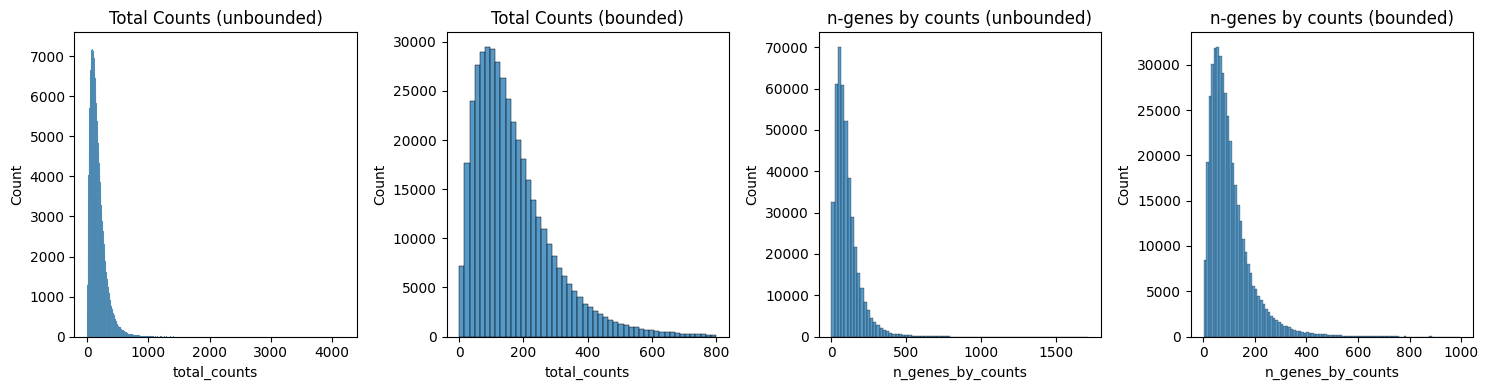

In [15]:
# QC
adata_cells.var_names_make_unique()
adata_cells.var["mt"] = adata_cells.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata_cells, 
                           qc_vars=["mt"], 
                           log1p=True, 
                           inplace=True)

# bin options for fomratting histograms
# Here, we set 'auto' for 1st figure, 80 bins for 2nd figure. and so on
hist_bin_options = ['auto', 50, 80, 100]

plot_qc_hist(adata_cells, 
         total_counts_cutoff = 800, # for visualization
         n_genes_high_cutoff = 1000, # for visualization
         n_genes_low_cutoff = 0, # for visualization
         bin_options = hist_bin_options)

Cells before filtering: 428621

Cells after count filter: 416785

cells after MT filter: 413271



/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Genes after minimum cells per gene filter: 12947



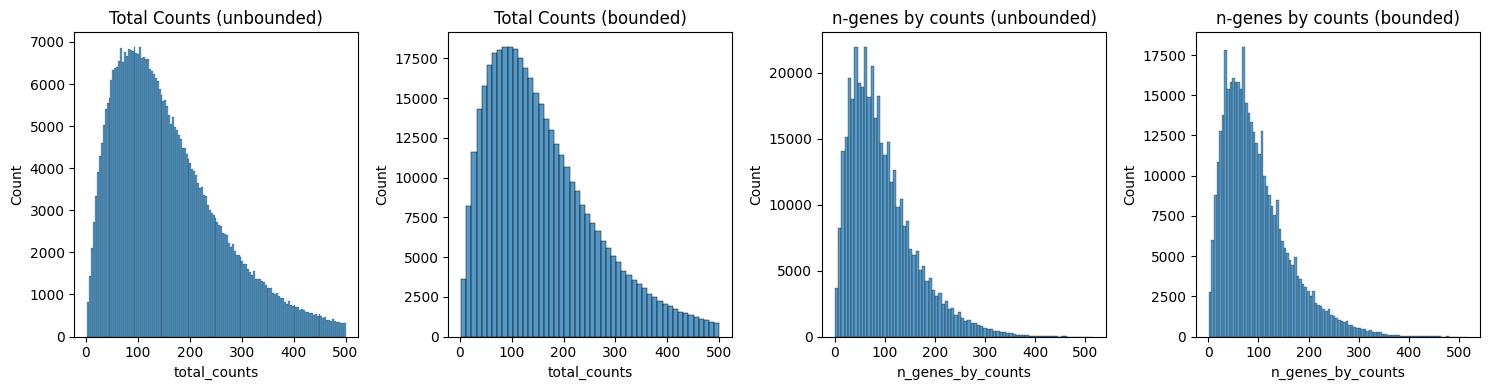

In [16]:
# initial filter of cells by their cell counts, MT count and gene counts
adata_filtred = adata_cells.copy()

adata_filtred = filter_cells(adata_filtred, 
             min_count=3, 
             max_count=500, 
             MT_filter=20, 
             gene_filter=100)

plot_qc_hist(adata_filtred,
         total_counts_cutoff = 800, # for visualization
         n_genes_high_cutoff = 1000, # for visualization
         n_genes_low_cutoff = 0, # for visualization
        bin_options = hist_bin_options)


## Normalize and scale

In [17]:
#Identify highly variable genes — modify filter_hvg to skip log1p inside
adata_normalized = adata_filtred.copy()
adata_normalized = normalize_total(adata_normalized)
sc.pp.log1p(adata_normalized)


--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 278.0819919151709, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 138.56808756655494, Min: 0.0



/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [18]:

sc.pp.highly_variable_genes(adata_normalized, n_top_genes=5000, flavor='seurat')

nsclc_marker_genes = sorted(list(set([
    # T cells
    'CD3D', 'CD3E', 'CD3G', 'CD2', 'CD7', 'TRAC', 'JUNB', 'S100A4', 'CD52', 'PFN1P1',
    'CD81', 'EEF1B2P3', 'CXCR4', 'CREM', 'IL32', 'TGIF1',

    # CD4+ T cells
    'CD4', 'IL7R', 'CCR7', 'SELL', 'FOXP3', 'CTLA4', 'TIGIT',

    # CD8+ T cells
    'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1', 'LAG3', 'PDCD1',

    # Regulatory T cells
    'IL2RA', 'IKZF2',

    # B cells
    'CD19', 'MS4A1', 'CD79A', 'CD79B', 'IGHD', 'IGHM', 'CD22', 'CD24',
    'CD74', 'HMGA1', 'CD52', 'PTPRC', 'HLA-DRA', 'CXCR4', 'SPCS3', 'LTB', 'IGKC',

    # Plasma cells
    'MZB1', 'JCHAIN', 'SDC1', 'XBP1',

    # NK cells
    'NCAM1', 'KLRB1', 'KLRD1', 'NKG7', 'GNLY', 'PRF1', 'FGFBP2',
    'IL32', 'FHL2', 'IL2RG', 'CD69', 'HOPX',

    # Dendritic cells
    'ITGAX', 'CD1C', 'CLEC9A', 'CD83', 'LAMP3', 'CCR7', 'HLA-DRA', 'BATF3',

    # Monocytes / Macrophages
    'CD14', 'CD68', 'LYZ', 'FCN1', 'S100A8', 'S100A9', 'ITGAM', 'MRC1', 'CD163',
    'NOS2', 'IL1B', 'TNF', 'ARG1', 'CD206', 'IL10',

    # Neutrophils
    'FCGR3B', 'CSF3R', 'ELANE', 'MPO', 'CEACAM8',

    # Endothelial
    'PECAM1', 'VWF', 'CDH5', 'KDR', 'CLDN5', 'ESAM', 'ENG', 'CD34', 'PROM1', 'PDPN',
    'TEK', 'FLT1', 'VCAM1', 'PTPRC', 'MCAM', 'ICAM1', 'FLT4',

    # Fibroblasts / CAFs
    'PDGFRA', 'PDGFRB', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A2', 'ACTA2', 'TAGLN', 'FAP', 'POSTN',
    'TCF21', 'FN',

    # Pericytes / Smooth muscle
    'RGS5', 'MYL9', 'MYLK', 'FHL2', 'ITGA1', 'EHD2', 'OGN', 'SNCG', 'FABP4',

    # Epithelial / Alveolar / Cancer cells
    'EPCAM', 'KRT8', 'KRT18', 'KRT19', 'SFTPC', 'SFTPB', 'AGER', 'PDPN', 'KRT7', 'KRT5', 'KRT14',
    'TP63', 'NGFR', 'MUC1', 'MUC16', 'BIRC5', 'MYC', 'SOX2', 'CCND1', 'CDKN2A', 'PD-L1',
    'EGFR', 'KRAS', 'TP53', 'TTF-1', 'NKX2-1', 'CEACAM5', 'CDH1', 'CLDN1',

    # Club/secretory cells
    'SCGB1A1', 'SCGB3A2', 'MUC5B',

    # Ciliated cells
    'FOXJ1', 'TPPP3', 'PIFO', 'DNAH5',

    # Goblet cells
    'MANF', 'KRT7', 'AQP3', 'AGR2', 'BACE2', 'TFF3', 'PHGR1', 'MUC4', 'MUC13', 'GUCA2A',

    # Enterocytes
    'CD55', 'ELF3', 'PLIN2', 'GSTM3', 'KLF5', 'CBR1', 'APOA1', 'CA1', 'PDHA1', 'EHF',

    # Enteroendocrine
    'NUCB2', 'FABP5', 'CPE', 'ALCAM', 'GCG', 'SST', 'CHGB', 'IAPP', 'CHGA', 'ENPP2',

    # Crypt cells / stem-like
    'HOPX', 'SLC12A2', 'MSI1', 'SMOC2', 'OLFM4', 'ASCL2', 'PROM1', 'BMI1', 'EPHB2', 'LRIG1',

    # Cancer stem cells
    'CD44', 'PROM1', 'ALDH1A1', 'ITGA6',

    # Immune checkpoints / tumor markers
    'PDCD1', 'CTLA4', 'HAVCR2', 'TIGIT', 'LAG3', 'CD274', 'PDCD1LG2',
    'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DQA1', 'HLA-DPB1'
])))

hvg_genes = adata_normalized.var_names[adata_normalized.var['highly_variable']].tolist()
combined_genes = list(set(hvg_genes + nsclc_marker_genes))
genes_to_keep = [g for g in combined_genes if g in adata_normalized.var_names]
adata_normalized = adata_normalized[:, genes_to_keep]
adata_normalized

View of AnnData object with n_obs × n_vars = 413271 × 5088
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell', 'log1p', 'hvg'
    obsm: 'spatial'

## Clustering

/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


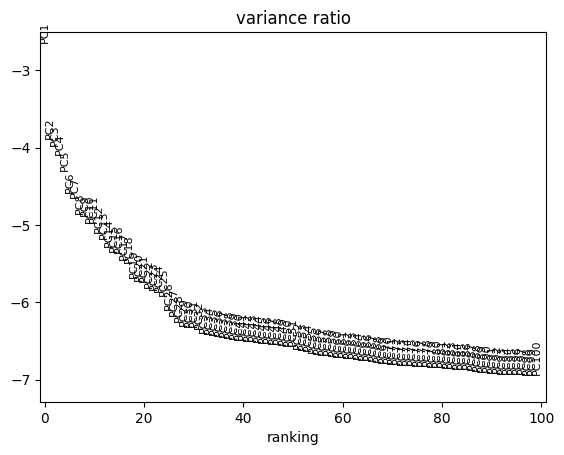

In [19]:
sc.tl.pca(adata_normalized, svd_solver='arpack',n_comps=100)
# “elbow” — the point where additional PCs contribute little variance — and use that number in n_pcs.
sc.pl.pca_variance_ratio(adata_normalized, log=True, n_pcs=100)

Clustering with resolution = 0.2


/tmp/ipykernel_595337/1838375495.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Clustering done, ploting...


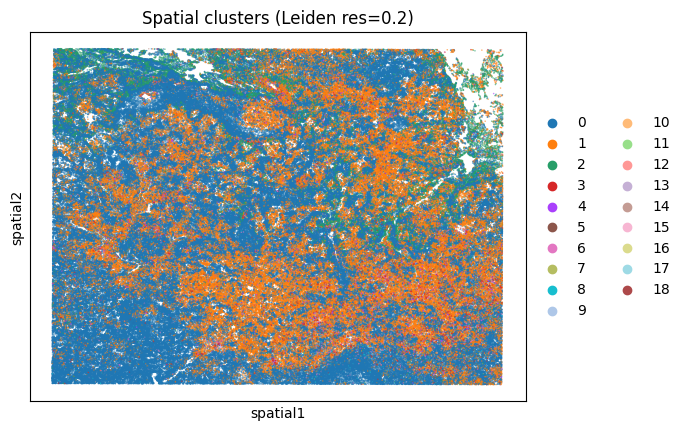

In [20]:
import scanpy as sc

# Parameters
NNei = 30
res = 0.2
nPCs = 30

# 1. Compute neighborhood graph
sc.pp.neighbors(adata_normalized, n_neighbors=NNei, n_pcs=nPCs)

print(f'Clustering with resolution = {res}')
# 2. Run Leiden clustering
leiden_key = f'nn_{NNei} leiden_{res}'
sc.tl.leiden(
    adata_normalized,
    resolution=res,
    key_added=leiden_key,
)
print(f'Clustering done, ploting...')

sc.pl.embedding(
    adata_normalized,
    basis="spatial",
    color=f'nn_{NNei} leiden_{res}',
    size=5,
    alpha=0.6,
    title=f"Spatial clusters (Leiden res={res})",
    show=False
)
plt.gca().invert_yaxis()
plt.show()



Generating UMAP for resolution = 0.2
UMAP done, ploting...


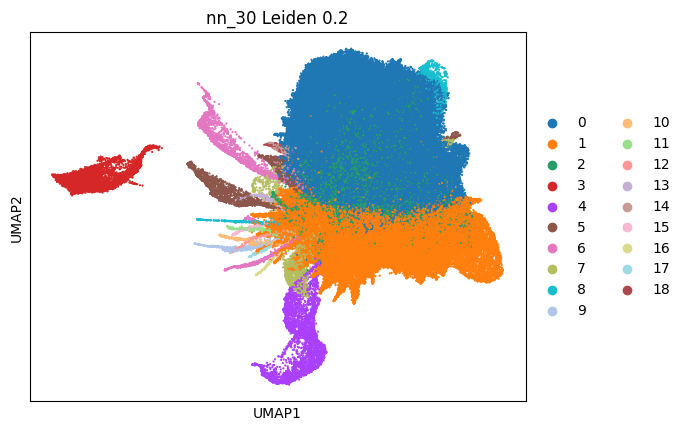

In [21]:
print(f'Generating UMAP for resolution = {res}')

# 3. Compute UMAP embedding
sc.tl.umap(adata_normalized)

print(f'UMAP done, ploting...')

# 5. Plot UMAP colored by clustering result
sc.pl.umap(
    adata_normalized,
    color=leiden_key,
    title=f'nn_{NNei} Leiden {res}',
    size=10  # adjust based on dataset
)


## Annotation

In [22]:
marker_dict = {
    'B cell': [
        'CD19', 'CD20', 'CD79A', 'CD79B','IGHM', 'MS4A1'
    ],
    'Basal cell': [
        'TP63', 'NGFR', 'MST1R'
    ],
    'CD4+ T cell': ['CD4'],
    'CD8+ T cell': ['CD8A'],
    'Cancer cell': [
        'EGFR', 'EPCAM', 'TTF-1', 'KRAS', 'TP53', 'NKX2-1',
        'TP63', 'CEACAM5', 'LOX'
    ],
    'Dendritic cell': [
        'CCL17', 'CD141', 'CD1A', 'CD1C', 'CD303', 'CD83'
    ],
    'Endothelial cell': [
        'CA4', 'CD31', 'CD34', 'CDH5', 'CLDN5', 'COL15A1', 'CPE',
        'DKK2', 'EDNRB', 'PECAM1', 'VWF', 'STEAP1', 'KDR', 'VEGFA'
    ],
    'Epithelial cell': [
        'AGER', 'CCDC153', 'CD326', 'CDH1', 'E-cadherin', 'EPCAM',
        'FOXJ1', 'KRT18', 'KRT19', 'KRT5', 'KRT7', 'KRT8', 'MUC5B',
        'SCGB3A2', 'SFTPB', 'SFTPC', 'TPPP3'
    ],
    'Fibroblast': ['COL1A1', 'COL1A2', 'PDGFRA', 'aSMA','FAP'],
    'Macrophage': [
        'APOE', 'CCL18', 'CCL2', 'CD11b', 'CD11c', 'CD14', 'CD163',
        'CD64', 'CD68', 'CD80', 'CD86', 'CSF1R', 'FN1', 'ITGAM',
        'MRC1', 'MS4A4A', 'SPP1', 'VCAN'
    ],
    'Mast cell': ['CPA3', 'KIT', 'TPSAB1', 'TPSB2'],
    'Monocyte': [
        'CD11b', 'CD14', 'CD163', 'CD68', 'FCN1', 'HLA-DR', 'IL1B', 'IL1R2'
    ],
    'Myeloid cell': ['CD68', 'LYZ'],
    'Natural killer cell': [
        'CD56', 'GNLY', 'KLRB1', 'KLRD1', 'KLRF1', 'NCAM1', 'NKG7'
    ],
    'Neutrophil': ['CD11b', 'CD15', 'CD16', 'CD66b', 'CSF3R', 'FCGR3B'],
    'Pericyte': ['PDGFRB'],
    'Stromal cell': ['ACTA2', 'PDGFRA'],
    'T cell': [
        'CD2', 'CD3', 'CD3D', 'CD3E', 'CD3G', 'CD4', 'CD8', 'CD8A',
        'CD8B', 'IL7R', 'LAG3', 'NKG7', 'TRAC'
    ],
    'Cancer stem cell': ['CD44', 'CD133', 'EpCAM', 'ALDH1A1']
}


In [23]:
adata_normalized.obs.sample()

,n_counts,n_bins,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,nn_30 leiden_0.2
231601,103.925364,9.0,48,3.89182,103.925364,4.653249,100.0,100.0,100.0,100.0,4.461947,1.697805,4.293415,0


categories: 0, 1, 2, etc.
var_group_labels: B cell, Basal cell, CD4+ T cell, etc.


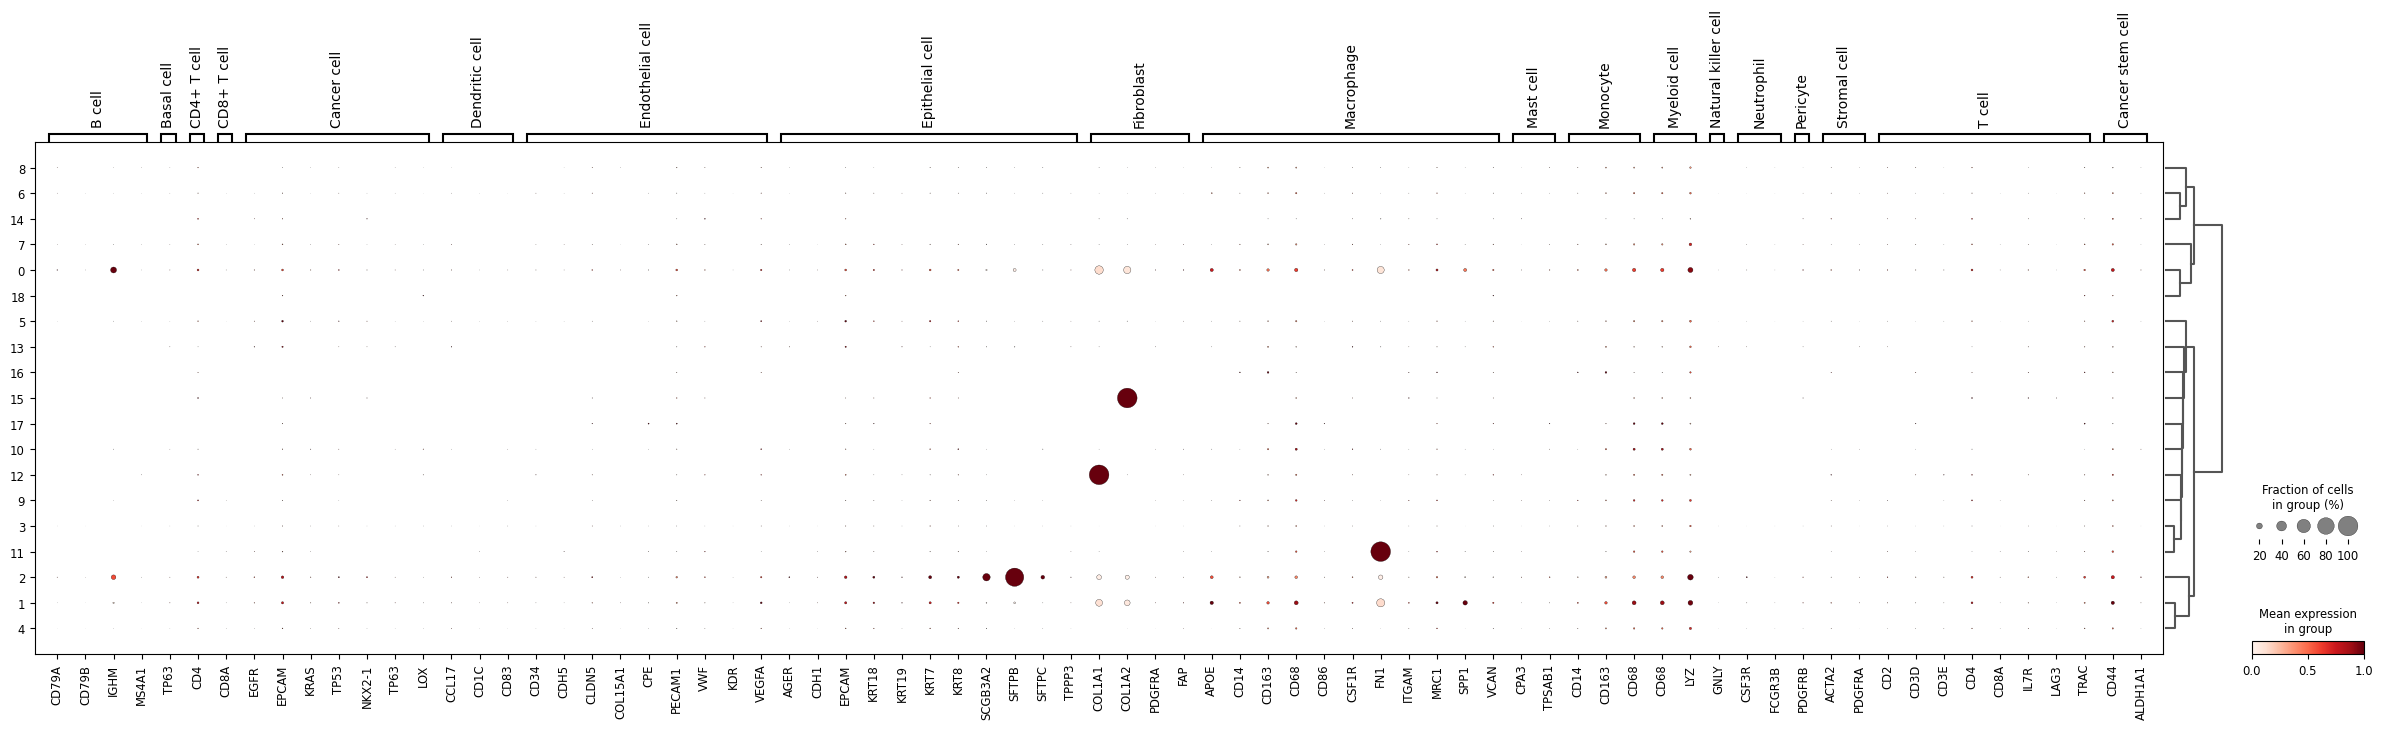

In [24]:
import numpy as np
import scanpy as sc
import scipy.sparse

cluster_key = 'nn_30 leiden_0.2'

adata_combined = adata_normalized.copy()
# Step 0: Ensure sliceable matrix
if not isinstance(adata_combined.X, np.ndarray) and not scipy.sparse.isspmatrix_csr(adata_combined.X):
    adata_combined.X = adata_combined.X.tocsr()

# Step 1: Get all marker genes that exist in the data
all_marker_genes = sorted(set(g for genes in marker_dict.values() for g in genes))
present_markers = [g for g in all_marker_genes if g in adata_combined.var_names]

# Step 2: Compute variance across all cells
X = adata_combined[:, present_markers].X
if not isinstance(X, np.ndarray):
    X = X.toarray()  # convert sparse to dense if needed
gene_variance = X.var(axis=0)

# Step 3: Filter genes with variance above threshold
var_threshold = 0.001  # You can tune this
variable_genes = [g for g, v in zip(present_markers, gene_variance) if v > var_threshold]

# Step 4: Filter marker dict
filtered_marker_dict = {
    celltype: [g for g in genes if g in variable_genes]
    for celltype, genes in marker_dict.items()
}
filtered_marker_dict = {k: v for k, v in filtered_marker_dict.items() if len(v) > 0}

# Step 5: Plot
sc.pl.dotplot(
    adata_combined,
    var_names=filtered_marker_dict,
    groupby=cluster_key,
    standard_scale='var',  # Normalize each gene
    cmap='Reds',
    dendrogram=True,
    show=True
)


# DE clusters

In [25]:
adata_normalized.obs.sample()

,n_counts,n_bins,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,nn_30 leiden_0.2
280998,92.26912,9.0,61,4.127134,92.26912,4.535489,90.021316,100.0,100.0,100.0,15.472254,2.801677,16.768616,1


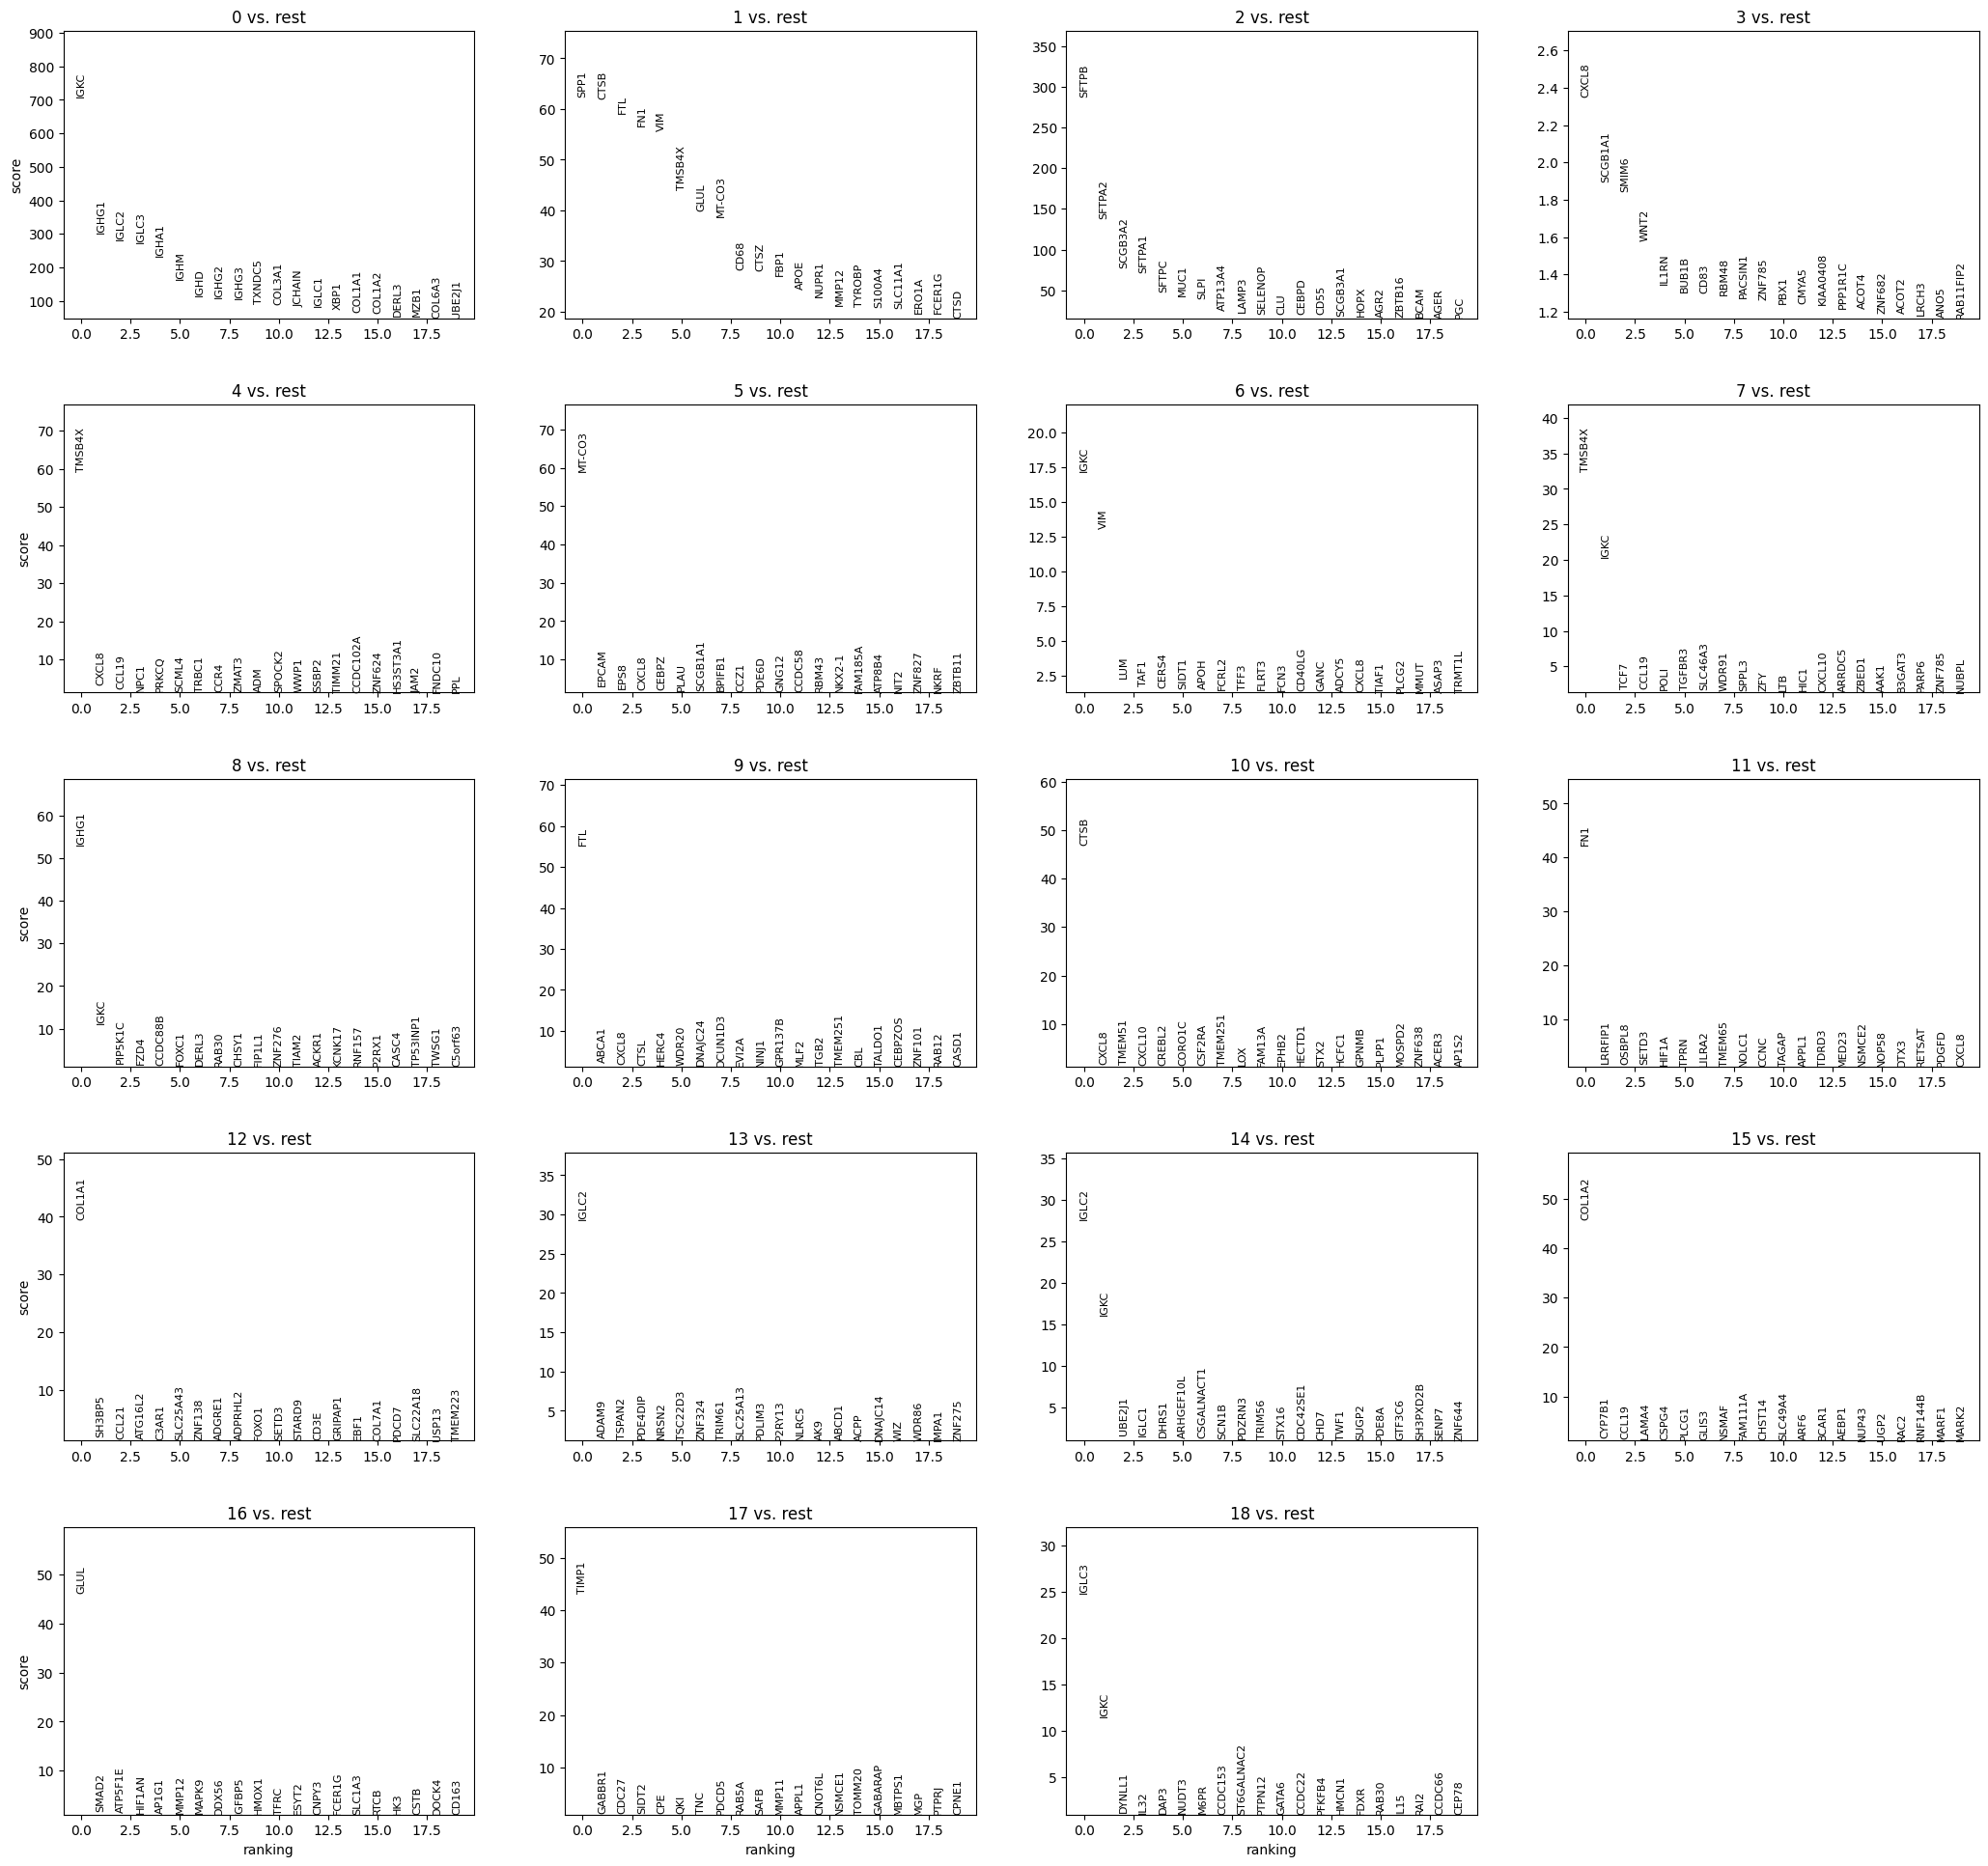

In [26]:
import scanpy as sc

# Make sure your AnnData object has cluster labels
cluster_key = "nn_30 leiden_0.2"  # change to your actual key, e.g., "nn_30 leiden_0.5"
if cluster_key not in adata_normalized.obs:
    raise ValueError(f"{cluster_key} not found in adata.obs")

# Perform differential expression
sc.tl.rank_genes_groups(
    adata_normalized,
    groupby=cluster_key,
    method='t-test_overestim_var',  # or 'wilcoxon', 'logreg'
    use_raw=False,
    n_genes=100,
)

# Plot top DE genes
sc.pl.rank_genes_groups(adata_normalized, n_genes=20, sharey=False)


In [27]:
adata_normalized.write(os.path.join('../', f"{sample_id}_clustered_leiden_allcells.h5ad"))
